In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import itertools as it
import glob
import numpy as np

from typing import Optional, List, Tuple
from copy import deepcopy

from ssvm_evaluation.plotting_utils import table__top_k_acc_per_dataset_with_significance

# Plots for the comparison of the different methods 
from ssvm_evaluation.plotting_utils import plot__01__a, plot__01__b

from ssvm_evaluation.utils import dict2fn, load_topk__comparison, load_topk__publication, load_topk__cand_set_info

In [2]:
def _check_onlyms(reference: pd.DataFrame, others: List[pd.DataFrame], n_samples: int = 1500, random_state: Optional[int] = None):    
    # Ensure input being a list
    if isinstance(others, pd.DataFrame): 
        others = [others]
    
    # We only need to ensure, that the Only MS performance is equal
    _ref = reference[reference["scoring_method"] == "Only MS"]
    _others = [o[o["scoring_method"] == "Only MS"] for o in others if len(o) > 0]
    
    # Go over a random sub-set of rows in the reference data
    n_tests = np.zeros(len(others))
    for _, (x, y, z) in _ref[["dataset", "eval_indx", "k"]].sample(n=n_samples, random_state=random_state).drop_duplicates().iterrows():
        # Top-k accuracy of the reference
        _acc_ref = _ref[(_ref["dataset"] == x) & (_ref["eval_indx"] == y) & (_ref["k"] == z)]["top_k_acc"]

        # Top-k accuracy of the others
        _acc_others = [_o[(_o["dataset"] == x) & (_o["eval_indx"] == y) & (_o["k"] == z)]["top_k_acc"] for _o in _others]
        
        # The top-k accuracy of the reference must be equal to the one of the others
        for i in range(len(_others)):
            if len(_acc_others[i]) == 0:
                continue
            
            try: 
                # assert _acc_ref.item() ==  _acc_others[i].item()
                assert np.allclose(_acc_ref.item(), _acc_others[i].item())
            except AssertionError:
                print(i, x, y, z, _acc_ref.item(), _acc_others[i].item())
                
            n_tests[i] += 1
    
    print("Performed tests:", n_tests)

# Experiment 1: Comparison of our LC-MS$^2$Struct method with other approaches in the literature

Here we compare the Structure Support Vector Machine (SSVM) with two (2) retention time (RT) based approaches and the method proposed by Bach et al. (2020) using predicted retention orders (RO).

### Only-MS$^2$
- Only the MS$^2$ information is used for the candidate ranking. 
- We apply each method to three (3) different base MS$^2$ scorers. 
 
### LC-MS$^2$Struct 
- Our proposed method.

### MS$^2$+RT
- Predicted RTs of the molecular candidates are compared with the measured RT
- Error threshold is used to prune the candidate list

### MS$^2$+logP
- PubChem XLogP3 values of the molecular candidates are related to the predicted XLogP3 value given the measured RT. 
- A linear model is trained to establish the XLogP3 prediction function given the RT.
- Candidate scores are using a weighted sum of RT (xlogp3) and MS$^2$ score. 

### MS$^2$+RO
- Method proposed by Bach et al. (2020)
- Retention orders (RO) are predicted using a RankSVM model. 
- RO and MS$^2$ scores are combined using by a weighted scoring.

## Load raw results for all three MS$^2$ scorers

In [3]:
agg_setting = {
    "marg_agg_fun": "average",
    "cand_agg_id": "inchikey1"
}

### MetFrag

MetFrag performs an in-silico fragmentation for each candidate structure and compares the predicted and observed (from the MS2 spectrum) fragments. 

In [4]:
# SSVM (Our method)
setting = {"ds": "*", "mol_feat": "FCFP__binary__all__2D", "mol_id": "cid", "ms2scorer": "metfrag__norm", "ssvm_flavor": "default", "lloss_mode": "mol_feat_fps"}
res__ssvm__metfrag = load_topk__publication(setting, agg_setting, basedir=os.path.join("massbank"), top_k_method="csi", load_max_model_number=True)
res__ssvm__metfrag__ALL_MODELS = load_topk__publication(setting, agg_setting, basedir=os.path.join("massbank"), top_k_method="csi", load_max_model_number=False)

# RT filtering
setting = {"ds": "*", "mol_feat": "bouwmeester__smiles_iso", "mol_id": "cid", "ms2scorer": "metfrag__norm", "rt_predictor": "svr", "score_int_app": "filtering__global"}
res__rtfilter__metfrag = load_topk__comparison(setting, agg_setting, os.path.join("..", "..", "..", "comparison", "massbank__exp_ver=3"), top_k_method="csi")

# XLogP3 
setting = {"ds": "*", "mol_feat": "xlogp3", "mol_id": "cid", "ms2scorer": "metfrag__norm", "rt_predictor": "linear_reg", "score_int_app": "score_combination"}
res__xlogp3__metfrag = load_topk__comparison(setting, agg_setting, os.path.join("..", "..", "..", "comparison", "massbank__exp_ver=3"), top_k_method="csi")

# Predicted ROs by Bach et al. (2020)
setting = {"ds": "*", "mol_feat": "substructure_count__smiles_iso", "mol_id": "cid", "ms2scorer": "metfrag__norm", "rt_predictor": "ranksvm", "score_int_app": "msms_pl_rt_score_integration"}
res__bach2020__metfrag = load_topk__comparison(setting, agg_setting, os.path.join("..", "..", "..", "comparison", "massbank__exp_ver=3"), top_k_method="csi")

# Perform some sanity checks
assert res__ssvm__metfrag["scoring_method"].nunique() == 2
if len(res__rtfilter__metfrag) > 0:
    assert res__rtfilter__metfrag["scoring_method"].nunique() == 2
if len(res__xlogp3__metfrag) > 0:
    assert res__xlogp3__metfrag["scoring_method"].nunique() == 2
if len(res__bach2020__metfrag) > 0:
    assert res__bach2020__metfrag["scoring_method"].nunique() == 2

_check_onlyms(res__ssvm__metfrag, [res__rtfilter__metfrag, res__xlogp3__metfrag, res__bach2020__metfrag])

Performed tests: [1479. 1479. 1500.]


#### Get false negative rate for the RT filtering approach

In [5]:
# RT (filtering)
setting = {"ds": "*", "mol_feat": "bouwmeester__smiles_iso", "mol_id": "cid", "ms2scorer": "metfrag__norm", "rt_predictor": "svr", "score_int_app": "filtering__global"}
cand_set_info__metfrag = load_topk__cand_set_info(setting, os.path.join("..", "..", "..", "comparison", "massbank__exp_ver=3"))

__tmp__ = cand_set_info__metfrag.groupby(["dataset"]) \
    .aggregate({"correct_structure_remains_after_filtering": lambda x: np.sum(~ x) / len(x) * 100}) \
    .rename({"correct_structure_remains_after_filtering": "false_negative_rate"}, axis=1) \
    .reset_index() \
    .round(1)
# print(__tmp__)

print("Average false negative rate:", np.round(np.sum(~ cand_set_info__metfrag["correct_structure_remains_after_filtering"]) / len(cand_set_info__metfrag) * 100, 1))

Average false negative rate: 4.7


#### Overview result table (LC-MS$^2$Struct)

In [6]:
tab = table__top_k_acc_per_dataset_with_significance(res__ssvm__metfrag, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                 5                 10            \
scoring_method    Only MS   MS + RT Only MS   MS + RT Only MS   MS + RT   
dataset n_samples                                                         
AC_003  15           12.3  | 18.3 *    38.3  | 40.7 *  | 47.1      46.5   
AU_000  15            9.5  | 16.8 *    32.9  | 39.9 *    43.5  | 49.1 *   
AU_002  14            4.7   | 7.0 *    20.4  | 26.5 *    31.9  | 38.3 *   
AU_003  15          | 5.2       3.9    19.1  | 25.1 *    27.8  | 36.9 *   
BML_000 15            3.1   | 6.1 *    16.8    | 18.4    23.1  | 25.6 *   
BML_001 15            3.5   | 6.1 *    16.7  | 22.9 *    22.1  | 31.2 *   
BS_000  15           12.0  | 13.8 *    22.9  | 28.3 *    27.7  | 37.3 *   
CE_001  1           | 2.1       0.0     8.6    | 10.3    17.7    | 23.1   
EA_000  15           12.1  | 25.6 *    36.3  | 50.8 *    47.5  | 63.3 *   
EA_001  15           14.5  | 25.3 *    39.3  | 52.3 *    50.2  | 59.7 *   
EA_002  6             4.4  | 10.4 *    23.6  | 34.6 *    38.9  | 48.5 *   
EA_003  6             8.0  | 14.8 *    31.4  | 41.7 *    46.7  | 54.7 *   
EQ_001  15            5.5  | 11.3 *    36.2  | 45.0 *    52.4  | 54.2 *   
EQ_003  15            7.1   | 9.7 *    29.7  | 39.5 *    44.1  | 56.4 *   
EQ_004  15            5.3   | 9.4 *    29.3  | 37.1 *    43.0  | 49.7 *   
EQ_006  15            5.5   | 9.1 *    26.9  | 36.3 *    35.6  | 46.7 *   
ET_002  1             7.8    | 10.0  | 23.9      20.0  | 30.4      26.0   
KW_000  1             1.9     | 5.5     6.7    | 21.8    13.6    | 25.5   
LQB_000 6             9.8    | 11.7    44.7    | 46.7    62.8    | 66.5   
LU_000  7             7.1  | 11.6 *    31.2  | 37.7 *    43.6  | 51.1 *   
LU_001  11            7.5   | 9.5 *    29.7  | 36.6 *    40.5  | 48.1 *   
NA_003  15            2.8  | 11.7 *    20.9  | 26.0 *    27.3  | 33.9 *   
PR_000  14           10.2  | 15.4 *    29.1  | 36.6 *    41.2  | 47.9 *   
PR_002  18            8.4  | 10.9 *    22.6  | 28.3 *    32.6  | 39.5 *   
RP_000  1             5.5     | 7.4    16.4    | 26.8    25.2    | 39.3   
RP_001  15            6.0   | 9.2 *    21.7  | 31.6 *    32.2  | 39.6 *   
SM_000  15            6.5  | 13.3 *    28.0  | 36.5 *    40.7  | 48.9 *   
SM_001  7             3.8   | 7.0 *    21.8  | 30.7 *    35.4  | 44.8 *   
UF_002  15            2.9   | 6.4 *    19.0  | 28.8 *    26.2  | 38.3 *   
UF_003  15            1.6   | 3.9 *    15.1  | 25.0 *    24.1  | 35.5 *   
UT_000  6             2.6     | 3.0    18.1    | 22.0    31.8  | 36.1 *   

k                      20            
scoring_method    Only MS   MS + RT  
dataset n_samples                    
AC_003  15           52.0  | 53.2 *  
AU_000  15           55.1  | 63.0 *  
AU_002  14           42.5  | 51.2 *  
AU_003  15           35.3  | 47.5 *  
BML_000 15           31.0  | 36.0 *  
BML_001 15           29.7  | 38.0 *  
BS_000  15           33.2  | 48.7 *  
CE_001  1            25.9    | 38.5  
EA_000  15           57.4  | 72.9 *  
EA_001  15           62.2  | 72.4 *  
EA_002  6            49.8  | 57.5 *  
EA_003  6            58.5  | 67.1 *  
EQ_001  15           59.4  | 66.4 *  
EQ_003  15           57.4  | 66.1 *  
EQ_004  15           55.2  | 59.9 *  
EQ_006  15           46.8  | 58.9 *  
ET_002  1          | 32.6      32.0  
KW_000  1            20.9    | 38.2  
LQB_000 6            82.2    | 82.4  
LU_000  7            54.0  | 60.9 *  
LU_001  11           51.3  | 57.3 *  
NA_003  15           37.3  | 41.7 *  
PR_000  14           57.1  | 63.8 *  
PR_002  18           43.5  | 50.2 *  
RP_000  1            32.1    | 44.9  
RP_001  15           42.0  | 49.1 *  
SM_000  15           51.2  | 60.7 *  
SM_001  7            50.1  | 60.2 *  
UF_002  15           34.0  | 50.0 *  
UF_003  15           34.2  | 46.5 *  
UT_000  6            49.5  | 53.9 *

Small datasets with only one evaluation samples. None of the datasets examples was used for training.

In [7]:
tab[tab["n_samples"] == 1].pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1               5               10              20  \
scoring_method    Only MS MS + RT Only MS MS + RT Only MS MS + RT Only MS   
dataset n_samples                                                           
CE_001  1           | 2.1     0.0     8.6  | 10.3    17.7  | 23.1    25.9   
ET_002  1             7.8  | 10.0  | 23.9    20.0  | 30.4    26.0  | 32.6   
KW_000  1             1.9   | 5.5     6.7  | 21.8    13.6  | 25.5    20.9   
RP_000  1             5.5   | 7.4    16.4  | 26.8    25.2  | 39.3    32.1   

k                          
scoring_method    MS + RT  
dataset n_samples          
CE_001  1          | 38.5  
ET_002  1            32.0  
KW_000  1          | 38.2  
RP_000  1          | 44.9

#### How does the number of SSVM models effects the performance?

Max-marginal values are averaged across the models.

/home/bach/.miniconda3/envs/lcms2struct_experiments/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


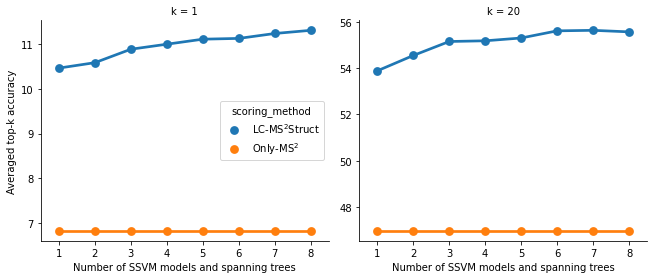

In [33]:
__tmp = res__ssvm__metfrag__ALL_MODELS[res__ssvm__metfrag__ALL_MODELS["k"].isin([1, 20])]
__tmp.loc[__tmp["scoring_method"] == "MS + RT", "scoring_method"] = "LC-MS$^2$Struct"
__tmp.loc[__tmp["scoring_method"] == "Only MS", "scoring_method"] = "Only-MS$^2$"

g = sns.catplot(data=__tmp, x="n_models", y="top_k_acc", hue="scoring_method", col="k", kind="point", sharey=False, ci=None, legend_out=False, aspect=1.15, height=4)
g.set_xlabels("Number of SSVM models and spanning trees")
g.set_ylabels("Averaged top-k accuracy")

g.savefig("NEW_number_of_RSTs__metfrag.svg")
g.savefig("NEW_number_of_RSTs__metfrag.pdf")

#### Overview tables for the alternative approaches

##### MS$^2$+RT

In [34]:
tab = table__top_k_acc_per_dataset_with_significance(res__rtfilter__metfrag, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                                   5   \
scoring_method    Only MS MS + RT (filtering__global) Only MS   
dataset n_samples                                               
AC_003  15           12.3                      | 12.8  | 38.3   
AU_000  15            9.5                       | 9.6  | 32.9   
AU_002  14            4.7                       | 4.8    20.4   
AU_003  15            5.2                       | 5.3  | 19.1   
BML_000 15          | 3.1                         2.8    16.8   
BML_001 15            3.5                     | 4.6 *    16.7   
BS_000  15         | 12.0                      | 12.0    22.9   
EA_000  15         | 12.1                        12.0  | 36.3   
EA_001  15           14.5                      | 14.8  | 39.3   
EA_002  6           | 4.4                         3.6  | 23.6   
EA_003  6           | 8.0                         7.5  | 31.4   
EQ_001  15            5.5                       | 5.6    36.2   
EQ_003  15          | 7.1                         6.1  | 29.7   
EQ_004  15          | 5.3                         5.2  | 29.3   
EQ_006  15          | 5.5                         4.0  | 26.9   
LQB_000 6             9.8                    | 14.0 *    44.7   
LU_000  7             7.1                       | 7.3  | 31.2   
LU_001  11          | 7.5                         7.1  | 29.7   
NA_003  15            2.8                     | 5.5 *    20.9   
PR_000  14           10.2                      | 10.8    29.1   
PR_002  18            8.4                     | 9.7 *    22.6   
RP_001  15          | 6.0                         5.7  | 21.7   
SM_000  15          | 6.5                       | 6.5  | 28.0   
SM_001  7             3.8                       | 4.0  | 21.8   
UF_002  15            2.9                       | 3.0  | 19.0   
UF_003  15          | 1.6                         1.4  | 15.1   
UT_000  6             2.6                     | 7.1 *    18.1   

k                                                  10  \
scoring_method    MS + RT (filtering__global) Only MS   
dataset n_samples                                       
AC_003  15                               37.1  | 47.1   
AU_000  15                               32.5  | 43.5   
AU_002  14                             | 20.5  | 31.9   
AU_003  15                             | 19.1    27.8   
BML_000 15                             | 17.5    23.1   
BML_001 15                           | 18.2 *    22.1   
BS_000  15                           | 24.1 *    27.7   
EA_000  15                               36.1  | 47.5   
EA_001  15                               38.3  | 50.2   
EA_002  6                                23.2  | 38.9   
EA_003  6                                31.2  | 46.7   
EQ_001  15                             | 36.7  | 52.4   
EQ_003  15                               28.0  | 44.1   
EQ_004  15                               28.5  | 43.0   
EQ_006  15                               25.1  | 35.6   
LQB_000 6                            | 55.9 *    62.8   
LU_000  7                                30.3  | 43.6   
LU_001  11                               29.4  | 40.5   
NA_003  15                             | 21.6    27.3   
PR_000  14                             | 29.6    41.2   
PR_002  18                           | 24.6 *    32.6   
RP_001  15                               21.6  | 32.2   
SM_000  15                               27.8  | 40.7   
SM_001  7                                21.0  | 35.4   
UF_002  15                               17.9  | 26.2   
UF_003  15                               14.3  | 24.1   
UT_000  6                            | 31.9 *    31.8   

k                                                  20  \
scoring_method    MS + RT (filtering__global) Only MS   
dataset n_samples                                       
AC_003  15                               45.6  | 52.0   
AU_000  15                               43.1  | 55.1   
AU_002  14                               31.8  | 42.5

##### MS$^2$+logP

In [35]:
tab = table__top_k_acc_per_dataset_with_significance(res__xlogp3__metfrag, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                                   5   \
scoring_method    Only MS MS + RT (score_combination) Only MS   
dataset n_samples                                               
AC_003  15         | 12.3                        10.8  | 38.3   
AU_000  15            9.5                    | 11.2 *    32.9   
AU_002  14            4.7                       | 5.3    20.4   
AU_003  15          | 5.2                         3.7  | 19.1   
BML_000 15            3.1                       | 3.3  | 16.8   
BML_001 15          | 3.5                         3.3  | 16.7   
BS_000  15           12.0                      | 12.5    22.9   
EA_000  15           12.1                    | 14.1 *  | 36.3   
EA_001  15           14.5                    | 15.4 *    39.3   
EA_002  6             4.4                       | 7.1    23.6   
EA_003  6             8.0                       | 8.5  | 31.4   
EQ_001  15            5.5                     | 8.2 *  | 36.2   
EQ_003  15            7.1                    | 12.6 *  | 29.7   
EQ_004  15            5.3                       | 6.5  | 29.3   
EQ_006  15            5.5                     | 8.6 *  | 26.9   
LQB_000 6           | 9.8                       | 9.8  | 44.7   
LU_000  7           | 7.1                         6.1    31.2   
LU_001  11            7.5                       | 7.9    29.7   
NA_003  15            2.8                       | 3.4  | 20.9   
PR_000  14           10.2                    | 11.9 *    29.1   
PR_002  18            8.4                       | 8.5    22.6   
RP_001  15          | 6.0                         5.7  | 21.7   
SM_000  15            6.5                     | 9.2 *    28.0   
SM_001  7             3.8                       | 5.7    21.8   
UF_002  15            2.9                       | 3.9  | 19.0   
UF_003  15            1.6                     | 3.0 *    15.1   
UT_000  6             2.6                       | 3.0  | 18.1   

k                                                  10  \
scoring_method    MS + RT (score_combination) Only MS   
dataset n_samples                                       
AC_003  15                               37.6  | 47.1   
AU_000  15                           | 36.3 *    43.5   
AU_002  14                             | 21.2    31.9   
AU_003  15                               15.9  | 27.8   
BML_000 15                               15.1  | 23.1   
BML_001 15                               16.1  | 22.1   
BS_000  15                           | 23.9 *  | 27.7   
EA_000  15                               35.9    47.5   
EA_001  15                           | 40.8 *    50.2   
EA_002  6                              | 26.3    38.9   
EA_003  6                                30.7    46.7   
EQ_001  15                               30.1  | 52.4   
EQ_003  15                             | 29.7  | 44.1   
EQ_004  15                               27.6    43.0   
EQ_006  15                               24.7  | 35.6   
LQB_000 6                              | 44.7  | 62.8   
LU_000  7                              | 34.2    43.6   
LU_001  11                           | 32.0 *    40.5   
NA_003  15                               14.9  | 27.3   
PR_000  14                           | 31.0 *    41.2   
PR_002  18                           | 24.8 *    32.6   
RP_001  15                               20.5  | 32.2   
SM_000  15                           | 31.7 *    40.7   
SM_001  7                              | 24.5    35.4   
UF_002  15                               18.8    26.2   
UF_003  15                           | 17.4 *    24.1   
UT_000  6                                17.9  | 31.8   

k                                                  20  \
scoring_method    MS + RT (score_combination) Only MS   
dataset n_samples                                       
AC_003  15                               46.7  | 52.0   
AU_000  15                           | 48.5 *    55.1   
AU_002  14                             | 33.4    42.5

##### MS$^2$+RO 

In [36]:
tab = table__top_k_acc_per_dataset_with_significance(res__bach2020__metfrag, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                                              5   \
scoring_method    Only MS MS + RT (msms_pl_rt_score_integration) Only MS   
dataset n_samples                                                          
AC_003  15           12.3                                 | 12.8    38.3   
AU_000  15            9.5                               | 14.1 *    32.9   
AU_002  14            4.7                                | 6.4 *    20.4   
AU_003  15          | 5.2                                    4.3  | 19.1   
BML_000 15            3.1                                | 4.1 *    16.8   
BML_001 15            3.5                                | 4.6 *    16.7   
BS_000  15         | 12.0                                   11.5    22.9   
CE_001  1           | 2.1                                    0.0   | 8.6   
EA_000  15           12.1                               | 13.7 *    36.3   
EA_001  15           14.5                               | 16.4 *    39.3   
EA_002  6             4.4                                  | 4.6    23.6   
EA_003  6             8.0                                 | 10.3    31.4   
EQ_001  15            5.5                                | 8.4 *    36.2   
EQ_003  15            7.1                                | 9.9 *    29.7   
EQ_004  15            5.3                                | 8.3 *    29.3   
EQ_006  15            5.5                                | 8.1 *    26.9   
ET_002  1             7.8                                  | 8.0  | 23.9   
KW_000  1             1.9                                  | 2.4     6.7   
LQB_000 6             9.8                               | 13.5 *    44.7   
LU_000  7             7.1                                  | 7.9    31.2   
LU_001  11            7.5                                | 9.3 *    29.7   
NA_003  15            2.8                                | 7.6 *    20.9   
PR_000  14           10.2                               | 14.2 *    29.1   
PR_002  18            8.4                               | 10.1 *    22.6   
RP_000  1           | 5.5                                    5.1    16.4   
RP_001  15          | 6.0                                    5.8    21.7   
SM_000  15            6.5                                | 7.7 *    28.0   
SM_001  7             3.8                                  | 5.1    21.8   
UF_002  15            2.9                                  | 3.1    19.0   
UF_003  15            1.6                                | 3.0 *    15.1   
UT_000  6             2.6                                | 6.5 *    18.1   

k                                                             10  \
scoring_method    MS + RT (msms_pl_rt_score_integration) Only MS   
dataset n_samples                                                  
AC_003  15                                        | 38.7  | 47.1   
AU_000  15                                      | 38.6 *    43.5   
AU_002  14                                      | 25.4 *    31.9   
AU_003  15                                          18.2  | 27.8   
BML_000 15                                        | 17.6    23.1   
BML_001 15                                      | 18.0 *    22.1   
BS_000  15                                      | 25.7 *    27.7   
CE_001  1                                            1.3  | 17.7   
EA_000  15                                      | 42.3 *    47.5   
EA_001  15                                      | 43.1 *    50.2   
EA_002  6                                         | 26.7    38.9   
EA_003  6                                       | 36.2 *    46.7   
EQ_001  15                                      | 39.3 *    52.4   
EQ_003  15                                      | 32.2 *    44.1   
EQ_004  15                                      | 31.3 *    43.0   
EQ_006  15                                      | 28.4 *    35.6   
ET_002  1                                           18.0  | 30.4   
KW_000  1                                         | 12.

## SIRIUS

In [37]:
# SSVM (Our method)
setting = {"ds": "*", "mol_feat": "FCFP__binary__all__2D", "mol_id": "cid", "ms2scorer": "sirius__norm", "ssvm_flavor": "default", "lloss_mode": "mol_feat_fps"}
res__ssvm__sirius = load_topk__publication(setting, agg_setting, basedir=os.path.join("massbank"), top_k_method="csi", load_max_model_number=True)
res__ssvm__sirius__ALL_MODELS = load_topk__publication(setting, agg_setting, basedir=os.path.join("massbank"), top_k_method="csi", load_max_model_number=False)

# RT filtering
setting = {"ds": "*", "mol_feat": "bouwmeester__smiles_iso", "mol_id": "cid", "ms2scorer": "sirius__norm", "rt_predictor": "svr", "score_int_app": "filtering__global"}
res__rtfilter__sirius = load_topk__comparison(setting, agg_setting, os.path.join("..", "..", "..", "comparison", "massbank__exp_ver=3"), top_k_method="csi")

# XLogP3 
setting = {"ds": "*", "mol_feat": "xlogp3", "mol_id": "cid", "ms2scorer": "sirius__norm", "rt_predictor": "linear_reg", "score_int_app": "score_combination"}
res__xlogp3__sirius = load_topk__comparison(setting, agg_setting, os.path.join("..", "..", "..", "comparison", "massbank__exp_ver=3"), top_k_method="csi")

# Predicted ROs by Bach et al. (2020)
setting = {"ds": "*", "mol_feat": "substructure_count__smiles_iso", "mol_id": "cid", "ms2scorer": "sirius__norm", "rt_predictor": "ranksvm", "score_int_app": "msms_pl_rt_score_integration"}
res__bach2020__sirius = load_topk__comparison(setting, agg_setting, os.path.join("..", "..", "..", "comparison", "massbank__exp_ver=3"), top_k_method="csi")

# Perform some sanity checks
assert res__ssvm__sirius["scoring_method"].nunique() == 2
if len(res__rtfilter__sirius) > 0:
    assert res__rtfilter__sirius["scoring_method"].nunique() == 2
if len(res__xlogp3__sirius) > 0:
    assert res__xlogp3__sirius["scoring_method"].nunique() == 2
if len(res__bach2020__sirius) > 0:
    assert res__bach2020__sirius["scoring_method"].nunique() == 2

_check_onlyms(res__ssvm__sirius, [res__rtfilter__sirius, res__xlogp3__sirius, res__bach2020__sirius])

Performed tests: [1482. 1482. 1500.]


#### Get false negative rate for the RT filtering approach

In [38]:
# RT (filtering)
setting = {"ds": "*", "mol_feat": "bouwmeester__smiles_iso", "mol_id": "cid", "ms2scorer": "sirius__norm", "rt_predictor": "svr", "score_int_app": "filtering__global"}
cand_set_info__sirius = load_topk__cand_set_info(setting, os.path.join("..", "..", "..", "comparison", "massbank__exp_ver=3"))

__tmp__ = cand_set_info__sirius.groupby(["dataset"]) \
    .aggregate({"correct_structure_remains_after_filtering": lambda x: np.sum(~ x) / len(x) * 100}) \
    .rename({"correct_structure_remains_after_filtering": "false_negative_rate"}, axis=1) \
    .reset_index() \
    .round(1)
# print(__tmp__)

print("Average false negative rate:", np.round(np.sum(~ cand_set_info__sirius["correct_structure_remains_after_filtering"]) / len(cand_set_info__sirius) * 100, 1))

Average false negative rate: 4.7


#### Overview result table (LC-MS$^2$Struct)

In [39]:
tab = table__top_k_acc_per_dataset_with_significance(res__ssvm__sirius, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                 5                 10            \
scoring_method    Only MS   MS + RT Only MS   MS + RT Only MS   MS + RT   
dataset n_samples                                                         
AC_003  15           27.2  | 29.5 *  | 58.5      58.4  | 63.2      62.7   
AU_000  15           30.4    | 30.9    56.1    | 56.5    64.3    | 64.7   
AU_002  14         | 41.7      41.5    64.5    | 65.1  | 72.1    | 72.1   
AU_003  15         | 38.0      37.1  | 66.0      65.3  | 72.0      71.6   
BML_000 15         | 21.9    | 21.9    57.1    | 57.9  | 65.6      65.3   
BML_001 15           28.8    | 28.9  | 66.7    | 66.7    73.6  | 74.3 *   
BS_000  15         | 30.0      29.2  | 58.7      58.4    68.0  | 70.0 *   
CE_001  1            52.6    | 53.8  | 74.4    | 74.4  | 82.1    | 82.1   
EA_000  15           41.9  | 43.2 *    62.8  | 63.3 *    66.5  | 68.8 *   
EA_001  15           40.3    | 41.1    68.7  | 70.1 *    75.6  | 77.2 *   
EA_002  6            38.9    | 40.0    64.8    | 66.1    72.7    | 73.4   
EA_003  6            55.0    | 55.4  | 80.8      80.4    85.0    | 85.3   
EQ_001  15           26.6  | 28.7 *    58.1  | 60.7 *  | 67.9      67.5   
EQ_003  15         | 38.9      37.2    63.3    | 64.1    73.1    | 73.3   
EQ_004  15           42.3    | 43.2    68.1    | 68.8  | 75.6      75.2   
EQ_006  15         | 49.1      48.6    72.1  | 73.7 *  | 78.7    | 78.7   
ET_002  1          | 48.0    | 48.0  | 78.0      74.0  | 84.0    | 84.0   
KW_000  1            23.6    | 25.5  | 45.5      41.8  | 54.5    | 54.5   
LQB_000 6            14.5  | 15.3 *    33.2    | 34.0    51.3    | 51.5   
LU_000  7          | 28.4      27.4    54.8  | 57.6 *    64.5  | 65.7 *   
LU_001  11         | 34.0      33.5  | 59.8    | 59.8  | 67.9      67.7   
NA_003  15           37.1  | 38.5 *  | 68.4      67.1  | 77.6      77.5   
PR_000  14           25.4    | 26.1    57.4    | 58.4    71.2  | 72.2 *   
PR_002  18         | 33.4      33.2  | 65.3    | 65.3  | 76.4      76.1   
RP_000  1          | 34.8    | 34.8  | 46.4    | 46.4  | 60.9    | 60.9   
RP_001  15           55.0  | 55.9 *    80.3  | 81.5 *  | 90.5      88.0   
SM_000  15           37.2  | 38.7 *    57.5    | 57.7    69.2  | 70.0 *   
SM_001  7            44.1    | 44.3    74.4    | 75.2    80.4    | 81.0   
UF_002  15           39.9  | 41.9 *    63.5  | 65.3 *    71.1  | 73.6 *   
UF_003  15         | 40.7      40.5    68.4  | 70.0 *    75.7    | 75.9   
UT_000  6            18.9    | 19.0    35.9    | 36.7    41.8  | 42.3 *   

k                      20            
scoring_method    Only MS   MS + RT  
dataset n_samples                    
AC_003  15         | 64.8      64.5  
AU_000  15         | 68.7      68.5  
AU_002  14         | 77.5    | 77.5  
AU_003  15           76.9    | 77.5  
BML_000 15           74.1  | 75.1 *  
BML_001 15           79.5    | 79.7  
BS_000  15           79.7    | 80.3  
CE_001  1          | 94.9    | 94.9  
EA_000  15           73.5  | 75.5 *  
EA_001  15           79.2    | 79.3  
EA_002  6          | 79.7    | 79.7  
EA_003  6          | 89.9    | 89.9  
EQ_001  15           68.9    | 69.2  
EQ_003  15           78.4  | 80.3 *  
EQ_004  15           78.7  | 79.3 *  
EQ_006  15           83.7    | 84.4  
ET_002  1            88.0    | 90.0  
KW_000  1          | 60.6      58.2  
LQB_000 6            72.0    | 72.6  
LU_000  7            73.8    | 74.6  
LU_001  11           74.0  | 75.3 *  
NA_003  15           79.6  | 80.3 *  
PR_000  14           79.1  | 79.5 *  
PR_002  18           83.0    | 83.3  
RP_000  1          | 68.1    | 68.1  
RP_001  15           93.3    | 93.5  
SM_000  15           78.3    | 79.2  
SM_001  7            85.2    | 85.4  
UF_002  15         | 78.8      78.1  
UF_003  15           81.7    | 81.9  
UT_000  6            55.6  | 56.4 *

Small datasets with only one evaluation samples. None of the datasets examples was used for training.

In [40]:
tab[tab["n_samples"] == 1].pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1               5               10              20  \
scoring_method    Only MS MS + RT Only MS MS + RT Only MS MS + RT Only MS   
dataset n_samples                                                           
CE_001  1            52.6  | 53.8  | 74.4  | 74.4  | 82.1  | 82.1  | 94.9   
ET_002  1          | 48.0  | 48.0  | 78.0    74.0  | 84.0  | 84.0    88.0   
KW_000  1            23.6  | 25.5  | 45.5    41.8  | 54.5  | 54.5  | 60.6   
RP_000  1          | 34.8  | 34.8  | 46.4  | 46.4  | 60.9  | 60.9  | 68.1   

k                          
scoring_method    MS + RT  
dataset n_samples          
CE_001  1          | 94.9  
ET_002  1          | 90.0  
KW_000  1            58.2  
RP_000  1          | 68.1

#### How does the number of SSVM models effects the performance?

Max-marginal values are averaged across the models.

/home/bach/.miniconda3/envs/lcms2struct_experiments/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


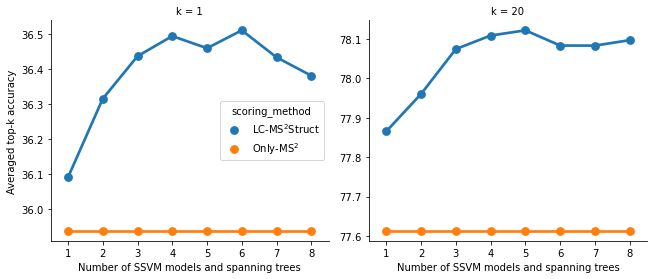

In [41]:
__tmp = res__ssvm__sirius__ALL_MODELS[res__ssvm__sirius__ALL_MODELS["k"].isin([1, 20])]
__tmp.loc[__tmp["scoring_method"] == "MS + RT", "scoring_method"] = "LC-MS$^2$Struct"
__tmp.loc[__tmp["scoring_method"] == "Only MS", "scoring_method"] = "Only-MS$^2$"

g = sns.catplot(data=__tmp, x="n_models", y="top_k_acc", hue="scoring_method", col="k", kind="point", sharey=False, ci=None, legend_out=False, aspect=1.15, height=4)
g.set_xlabels("Number of SSVM models and spanning trees")
g.set_ylabels("Averaged top-k accuracy")

g.savefig("NEW_number_of_RSTs__sirius.svg")
g.savefig("NEW_number_of_RSTs__sirius.pdf")

#### Overview tables for the alternative approaches

##### MS$^2$+RT

In [42]:
tab = table__top_k_acc_per_dataset_with_significance(res__rtfilter__sirius, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                                   5   \
scoring_method    Only MS MS + RT (filtering__global) Only MS   
dataset n_samples                                               
AC_003  15         | 27.2                        27.1  | 58.5   
AU_000  15           30.4                    | 30.8 *  | 56.1   
AU_002  14         | 41.7                        40.4  | 64.5   
AU_003  15         | 38.0                        36.5  | 66.0   
BML_000 15         | 21.9                        20.9  | 57.1   
BML_001 15         | 28.8                        27.5  | 66.7   
BS_000  15           30.0                    | 31.7 *    58.7   
EA_000  15         | 41.9                        41.5  | 62.8   
EA_001  15         | 40.3                        38.3  | 68.7   
EA_002  6          | 38.9                        37.6  | 64.8   
EA_003  6          | 55.0                        54.1  | 80.8   
EQ_001  15         | 26.6                        24.5  | 58.1   
EQ_003  15         | 38.9                        37.2  | 63.3   
EQ_004  15         | 42.3                        39.9  | 68.1   
EQ_006  15         | 49.1                        46.7  | 72.1   
LQB_000 6            14.5                    | 15.7 *    33.2   
LU_000  7          | 28.4                        27.0  | 54.8   
LU_001  11         | 34.0                        33.6  | 59.8   
NA_003  15         | 37.1                        36.7  | 68.4   
PR_000  14           25.4                      | 25.7  | 57.4   
PR_002  18         | 33.4                        33.1  | 65.3   
RP_001  15         | 55.0                        53.0  | 80.3   
SM_000  15         | 37.2                        34.5  | 57.5   
SM_001  7          | 44.1                        42.2  | 74.4   
UF_002  15         | 39.9                        37.7  | 63.5   
UF_003  15         | 40.7                        39.2  | 68.4   
UT_000  6            18.9                    | 22.9 *    35.9   

k                                                  10  \
scoring_method    MS + RT (filtering__global) Only MS   
dataset n_samples                                       
AC_003  15                               57.1  | 63.2   
AU_000  15                               55.5  | 64.3   
AU_002  14                               62.5  | 72.1   
AU_003  15                               63.6  | 72.0   
BML_000 15                               54.8  | 65.6   
BML_001 15                               65.5  | 73.6   
BS_000  15                             | 58.8  | 68.0   
EA_000  15                               61.1  | 66.5   
EA_001  15                               66.1  | 75.6   
EA_002  6                                62.5  | 72.7   
EA_003  6                                79.1  | 85.0   
EQ_001  15                               56.0  | 67.9   
EQ_003  15                               60.5  | 73.1   
EQ_004  15                               65.2  | 75.6   
EQ_006  15                               69.7  | 78.7   
LQB_000 6                            | 37.7 *    51.3   
LU_000  7                                52.8  | 64.5   
LU_001  11                               58.0  | 67.9   
NA_003  15                               67.6  | 77.6   
PR_000  14                               56.8  | 71.2   
PR_002  18                               64.1  | 76.4   
RP_001  15                               75.7  | 90.5   
SM_000  15                               53.0  | 69.2   
SM_001  7                                70.2  | 80.4   
UF_002  15                               60.4  | 71.1   
UF_003  15                               66.1  | 75.7   
UT_000  6                            | 38.8 *    41.8   

k                                                  20  \
scoring_method    MS + RT (filtering__global) Only MS   
dataset n_samples                                       
AC_003  15                               61.0  | 64.8   
AU_000  15                               63.9  | 68.7   
AU_002  14                               69.7  | 77.5

##### MS$^2$+logP

In [43]:
tab = table__top_k_acc_per_dataset_with_significance(res__xlogp3__sirius, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                                   5   \
scoring_method    Only MS MS + RT (score_combination) Only MS   
dataset n_samples                                               
AC_003  15           27.2                      | 27.9  | 58.5   
AU_000  15           30.4                      | 31.0    56.1   
AU_002  14         | 41.7                        41.3    64.5   
AU_003  15         | 38.0                        33.9  | 66.0   
BML_000 15           21.9                    | 24.7 *  | 57.1   
BML_001 15         | 28.8                        27.5    66.7   
BS_000  15         | 30.0                      | 30.0  | 58.7   
EA_000  15           41.9                    | 43.9 *    62.8   
EA_001  15           40.3                      | 41.1  | 68.7   
EA_002  6            38.9                      | 40.7    64.8   
EA_003  6          | 55.0                        54.9  | 80.8   
EQ_001  15           26.6                    | 27.9 *    58.1   
EQ_003  15         | 38.9                        34.8  | 63.3   
EQ_004  15         | 42.3                        41.7  | 68.1   
EQ_006  15         | 49.1                        47.3    72.1   
LQB_000 6          | 14.5                      | 14.5  | 33.2   
LU_000  7            28.4                      | 28.7  | 54.8   
LU_001  11         | 34.0                        33.1    59.8   
NA_003  15         | 37.1                        32.1  | 68.4   
PR_000  14           25.4                      | 25.8  | 57.4   
PR_002  18         | 33.4                        33.3  | 65.3   
RP_001  15           55.0                    | 55.9 *    80.3   
SM_000  15         | 37.2                        35.3  | 57.5   
SM_001  7          | 44.1                      | 44.1  | 74.4   
UF_002  15         | 39.9                        38.8  | 63.5   
UF_003  15         | 40.7                        40.1  | 68.4   
UT_000  6            18.9                      | 19.0    35.9   

k                                                  10  \
scoring_method    MS + RT (score_combination) Only MS   
dataset n_samples                                       
AC_003  15                               56.1  | 63.2   
AU_000  15                           | 58.2 *    64.3   
AU_002  14                             | 64.9  | 72.1   
AU_003  15                               63.5  | 72.0   
BML_000 15                               51.6  | 65.6   
BML_001 15                             | 66.9  | 73.6   
BS_000  15                               58.0  | 68.0   
EA_000  15                           | 64.8 *    66.5   
EA_001  15                               67.6    75.6   
EA_002  6                              | 65.8    72.7   
EA_003  6                                79.8  | 85.0   
EQ_001  15                             | 58.8  | 67.9   
EQ_003  15                               60.8  | 73.1   
EQ_004  15                               67.5  | 75.6   
EQ_006  15                           | 75.7 *    78.7   
LQB_000 6                              | 33.2  | 51.3   
LU_000  7                              | 54.8    64.5   
LU_001  11                             | 60.2    67.9   
NA_003  15                               65.6  | 77.6   
PR_000  14                               57.1  | 71.2   
PR_002  18                               64.0  | 76.4   
RP_001  15                           | 81.7 *  | 90.5   
SM_000  15                               56.5  | 69.2   
SM_001  7                              | 74.4  | 80.4   
UF_002  15                               62.8  | 71.1   
UF_003  15                               68.3    75.7   
UT_000  6                              | 36.5    41.8   

k                                                  20  \
scoring_method    MS + RT (score_combination) Only MS   
dataset n_samples                                       
AC_003  15                               61.9    64.8   
AU_000  15                           | 64.9 *    68.7   
AU_002  14                             | 72.1  | 77.5

##### MS$^2$+RO 

In [44]:
tab = table__top_k_acc_per_dataset_with_significance(res__bach2020__sirius, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                                              5   \
scoring_method    Only MS MS + RT (msms_pl_rt_score_integration) Only MS   
dataset n_samples                                                          
AC_003  15           27.2                               | 28.9 *  | 58.5   
AU_000  15           30.4                                 | 31.0    56.1   
AU_002  14           41.7                                 | 41.9    64.5   
AU_003  15         | 38.0                                 | 38.0  | 66.0   
BML_000 15           21.9                               | 24.0 *    57.1   
BML_001 15         | 28.8                                   28.7  | 66.7   
BS_000  15           30.0                                 | 30.5    58.7   
CE_001  1          | 52.6                                   33.3  | 74.4   
EA_000  15           41.9                                 | 42.3    62.8   
EA_001  15           40.3                               | 42.8 *    68.7   
EA_002  6            38.9                                 | 41.7    64.8   
EA_003  6            55.0                               | 57.0 *    80.8   
EQ_001  15           26.6                               | 27.9 *    58.1   
EQ_003  15         | 38.9                                   38.5    63.3   
EQ_004  15         | 42.3                                   41.3  | 68.1   
EQ_006  15         | 49.1                                   47.4    72.1   
ET_002  1          | 48.0                                   44.0  | 78.0   
KW_000  1          | 23.6                                 | 23.6    45.5   
LQB_000 6            14.5                               | 20.5 *    33.2   
LU_000  7            28.4                                 | 29.4    54.8   
LU_001  11         | 34.0                                   33.3    59.8   
NA_003  15           37.1                               | 38.4 *  | 68.4   
PR_000  14           25.4                               | 27.8 *    57.4   
PR_002  18           33.4                                 | 34.8    65.3   
RP_000  1          | 34.8                                 | 34.8    46.4   
RP_001  15           55.0                               | 56.5 *    80.3   
SM_000  15         | 37.2                                   37.0    57.5   
SM_001  7            44.1                                 | 45.5    74.4   
UF_002  15           39.9                               | 42.5 *    63.5   
UF_003  15           40.7                                 | 41.6    68.4   
UT_000  6          | 18.9                                   18.6  | 35.9   

k                                                             10  \
scoring_method    MS + RT (msms_pl_rt_score_integration) Only MS   
dataset n_samples                                                  
AC_003  15                                          58.4  | 63.2   
AU_000  15                                        | 56.7    64.3   
AU_002  14                                      | 65.7 *    72.1   
AU_003  15                                          65.5  | 72.0   
BML_000 15                                        | 58.0    65.6   
BML_001 15                                        | 66.7    73.6   
BS_000  15                                      | 62.5 *    68.0   
CE_001  1                                           64.1  | 82.1   
EA_000  15                                      | 64.7 *    66.5   
EA_001  15                                        | 68.8    75.6   
EA_002  6                                         | 66.6    72.7   
EA_003  6                                       | 81.7 *    85.0   
EQ_001  15                                      | 60.4 *    67.9   
EQ_003  15                                      | 68.1 *    73.1   
EQ_004  15                                          67.3  | 75.6   
EQ_006  15                                      | 74.8 *    78.7   
ET_002  1                                           72.0  | 84.0   
KW_000  1                                         | 49.

## CFM-ID

In [45]:
# SSVM (Our method)
setting = {"ds": "*", "mol_feat": "FCFP__binary__all__2D", "mol_id": "cid", "ms2scorer": "cfmid4__norm", "ssvm_flavor": "default", "lloss_mode": "mol_feat_fps"}
res__ssvm__cfmid4 = load_topk__publication(setting, agg_setting, basedir=os.path.join("massbank"), top_k_method="csi", load_max_model_number=True)
res__ssvm__cfmid4__ALL_MODELS = load_topk__publication(setting, agg_setting, basedir=os.path.join("massbank"), top_k_method="csi", load_max_model_number=False)

# RT filtering
setting = {"ds": "*", "mol_feat": "bouwmeester__smiles_iso", "mol_id": "cid", "ms2scorer": "cfmid4__norm", "rt_predictor": "svr", "score_int_app": "filtering__global"}
res__rtfilter__cfmid4 = load_topk__comparison(setting, agg_setting, os.path.join("..", "..", "..", "comparison", "massbank__exp_ver=3"), top_k_method="csi")

# XLogP3 
setting = {"ds": "*", "mol_feat": "xlogp3", "mol_id": "cid", "ms2scorer": "cfmid4__norm", "rt_predictor": "linear_reg", "score_int_app": "score_combination"}
res__xlogp3__cfmid4 = load_topk__comparison(setting, agg_setting, os.path.join("..", "..", "..", "comparison", "massbank__exp_ver=3"), top_k_method="csi")

# Predicted ROs by Bach et al. (2020)
setting = {"ds": "*", "mol_feat": "substructure_count__smiles_iso", "mol_id": "cid", "ms2scorer": "cfmid4__norm", "rt_predictor": "ranksvm", "score_int_app": "msms_pl_rt_score_integration"}
res__bach2020__cfmid4 = load_topk__comparison(setting, agg_setting, os.path.join("..", "..", "..", "comparison", "massbank__exp_ver=3"), top_k_method="csi")

# Perform some sanity checks
assert res__ssvm__cfmid4["scoring_method"].nunique() == 2
if len(res__rtfilter__cfmid4) > 0:
    assert res__rtfilter__cfmid4["scoring_method"].nunique() == 2
if len(res__xlogp3__cfmid4) > 0:
    assert res__xlogp3__cfmid4["scoring_method"].nunique() == 2
if len(res__bach2020__cfmid4) > 0:
    assert res__bach2020__cfmid4["scoring_method"].nunique() == 2

_check_onlyms(res__ssvm__cfmid4, [res__rtfilter__cfmid4, res__xlogp3__cfmid4, res__bach2020__cfmid4])

Performed tests: [1483. 1483. 1500.]


#### Get false negative rate for the RT filtering approach

In [46]:
# RT (filtering)
setting = {"ds": "*", "mol_feat": "bouwmeester__smiles_iso", "mol_id": "cid", "ms2scorer": "cfmid4__norm", "rt_predictor": "svr", "score_int_app": "filtering__global"}
cand_set_info__cfmid4 = load_topk__cand_set_info(setting, os.path.join("..", "..", "..", "comparison", "massbank__exp_ver=3"))

__tmp__ = cand_set_info__cfmid4.groupby(["dataset"]) \
    .aggregate({"correct_structure_remains_after_filtering": lambda x: np.sum(~ x) / len(x) * 100}) \
    .rename({"correct_structure_remains_after_filtering": "false_negative_rate"}, axis=1) \
    .reset_index() \
    .round(1)
# print(__tmp__)

print("Average false negative rate:", np.round(np.sum(~ cand_set_info__cfmid4["correct_structure_remains_after_filtering"]) / len(cand_set_info__cfmid4) * 100, 1))

Average false negative rate: 4.7


#### Overview result table (LC-MS$^2$Struct)

In [47]:
tab = table__top_k_acc_per_dataset_with_significance(res__ssvm__cfmid4, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                 5                 10            \
scoring_method    Only MS   MS + RT Only MS   MS + RT Only MS   MS + RT   
dataset n_samples                                                         
AC_003  15            6.9   | 7.9 *    20.9  | 24.0 *    25.3  | 30.5 *   
AU_000  15            8.8  | 14.7 *    32.2  | 37.9 *    41.8  | 48.4 *   
AU_002  14            7.0     | 7.5    21.8  | 24.4 *    30.8  | 36.6 *   
AU_003  15            2.4   | 7.6 *    20.5  | 29.7 *    34.8  | 43.1 *   
BML_000 15          | 4.1     | 4.1    15.6  | 19.3 *    21.3  | 27.2 *   
BML_001 15            0.9   | 3.7 *    18.7  | 24.7 *    26.7  | 37.1 *   
BS_000  15            6.1   | 9.7 *    20.5  | 24.5 *    25.2  | 34.7 *   
CE_001  1             5.1     | 7.7  | 15.4    | 15.4    17.9    | 25.6   
EA_000  15            7.3  | 14.1 *    23.5  | 33.1 *    33.3  | 41.7 *   
EA_001  15            7.6  | 15.5 *    25.2  | 35.6 *    37.2  | 48.5 *   
EA_002  6             4.3   | 7.6 *    18.9  | 22.6 *    29.7  | 33.2 *   
EA_003  6             8.5  | 13.7 *    27.8  | 34.5 *    39.6  | 44.6 *   
EQ_001  15            8.8  | 12.4 *    33.1  | 38.5 *    40.5  | 46.2 *   
EQ_003  15            2.0   | 4.1 *    19.0  | 26.1 *    32.3  | 40.9 *   
EQ_004  15            7.8   | 9.6 *    26.9  | 32.8 *    36.1  | 45.2 *   
EQ_006  15            8.8  | 11.1 *    23.1  | 29.9 *    30.9  | 36.5 *   
ET_002  1             4.0     | 8.0    20.0    | 26.0  | 34.0    | 34.0   
KW_000  1             1.8     | 5.5    10.9    | 16.4    16.9    | 25.5   
LQB_000 6            12.1  | 18.4 *    51.4    | 54.0    68.1  | 71.4 *   
LU_000  7             3.8   | 5.3 *    20.7  | 24.6 *    32.7  | 38.0 *   
LU_001  11            6.2   | 8.0 *    25.9  | 32.3 *    35.3  | 41.2 *   
NA_003  15            1.7     | 1.9    11.0  | 16.7 *    16.5  | 22.5 *   
PR_000  14            8.9  | 10.6 *    27.8  | 33.7 *    40.5  | 49.1 *   
PR_002  18            7.9   | 9.5 *    25.9  | 31.0 *    35.8  | 43.2 *   
RP_000  1             4.6     | 7.2    20.0    | 23.2    26.7    | 29.0   
RP_001  15            7.5  | 13.7 *    23.9  | 32.7 *    36.3  | 43.6 *   
SM_000  15            4.8   | 8.8 *    21.0  | 26.5 *    27.7  | 38.4 *   
SM_001  7             3.7   | 7.3 *    22.5  | 28.3 *    35.6  | 41.7 *   
UF_002  15            1.7   | 3.3 *    19.6    | 20.1    28.3  | 30.7 *   
UF_003  15            2.7   | 6.4 *    22.9  | 28.3 *    30.3  | 36.5 *   
UT_000  6             9.8    | 10.8    42.6    | 44.5    58.1    | 59.1   

k                      20            
scoring_method    Only MS   MS + RT  
dataset n_samples                    
AC_003  15           36.4  | 40.3 *  
AU_000  15           53.4  | 58.3 *  
AU_002  14           39.5  | 47.6 *  
AU_003  15           50.1  | 60.7 *  
BML_000 15           30.9  | 40.1 *  
BML_001 15           36.4  | 47.7 *  
BS_000  15           35.2  | 48.5 *  
CE_001  1          | 46.2      43.6  
EA_000  15           40.9  | 48.0 *  
EA_001  15           49.2  | 58.0 *  
EA_002  6            37.9  | 42.8 *  
EA_003  6            47.2  | 56.0 *  
EQ_001  15           52.8  | 61.5 *  
EQ_003  15           38.5  | 48.3 *  
EQ_004  15           49.7  | 55.6 *  
EQ_006  15           40.7  | 44.5 *  
ET_002  1          | 40.0    | 40.0  
KW_000  1            27.3    | 36.4  
LQB_000 6            81.9  | 84.0 *  
LU_000  7            44.0  | 49.2 *  
LU_001  11           44.6  | 50.6 *  
NA_003  15           29.6  | 32.4 *  
PR_000  14           54.1  | 61.5 *  
PR_002  18           49.5  | 57.0 *  
RP_000  1            33.0    | 47.8  
RP_001  15           45.1  | 55.2 *  
SM_000  15           46.4  | 51.1 *  
SM_001  7            48.9  | 53.8 *  
UF_002  15           35.9  | 40.5 *  
UF_003  15           36.4  | 44.8 *  
UT_000  6            71.7  | 75.0 *

Small datasets with only one evaluation samples. None of the datasets examples was used for training.

In [48]:
tab[tab["n_samples"] == 1].pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1               5               10              20  \
scoring_method    Only MS MS + RT Only MS MS + RT Only MS MS + RT Only MS   
dataset n_samples                                                           
CE_001  1             5.1   | 7.7  | 15.4  | 15.4    17.9  | 25.6  | 46.2   
ET_002  1             4.0   | 8.0    20.0  | 26.0  | 34.0  | 34.0  | 40.0   
KW_000  1             1.8   | 5.5    10.9  | 16.4    16.9  | 25.5    27.3   
RP_000  1             4.6   | 7.2    20.0  | 23.2    26.7  | 29.0    33.0   

k                          
scoring_method    MS + RT  
dataset n_samples          
CE_001  1            43.6  
ET_002  1          | 40.0  
KW_000  1          | 36.4  
RP_000  1          | 47.8

#### How does the number of SSVM models effects the performance?

Max-marginal values are averaged across the models.

/home/bach/.miniconda3/envs/lcms2struct_experiments/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


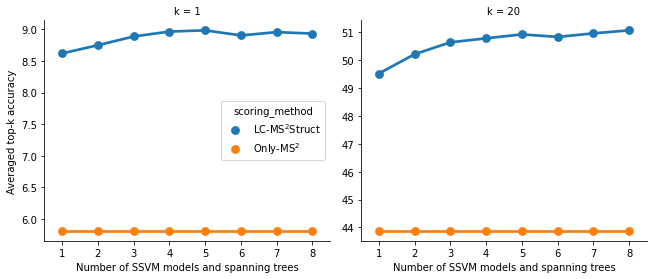

In [49]:
__tmp = res__ssvm__cfmid4__ALL_MODELS[res__ssvm__cfmid4__ALL_MODELS["k"].isin([1, 20])]
__tmp.loc[__tmp["scoring_method"] == "MS + RT", "scoring_method"] = "LC-MS$^2$Struct"
__tmp.loc[__tmp["scoring_method"] == "Only MS", "scoring_method"] = "Only-MS$^2$"

g = sns.catplot(data=__tmp, x="n_models", y="top_k_acc", hue="scoring_method", col="k", kind="point", sharey=False, ci=None, legend_out=False, aspect=1.15, height=4)
g.set_xlabels("Number of SSVM models and spanning trees")
g.set_ylabels("Averaged top-k accuracy")

g.savefig("NEW_number_of_RSTs__cfmid4.svg")
g.savefig("NEW_number_of_RSTs__cfmid4.pdf")

#### Overview tables for the alternative approaches

##### MS$^2$+RT

In [25]:
tab = table__top_k_acc_per_dataset_with_significance(res__rtfilter__cfmid4, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                                   5   \
scoring_method    Only MS MS + RT (filtering__global) Only MS   
dataset n_samples                                               
AC_003  15          | 6.9                       | 6.9    20.9   
AU_000  15            8.8                       | 8.9  | 32.2   
AU_002  14          | 7.0                       | 7.0    21.8   
AU_003  15            2.4                     | 3.1 *  | 20.5   
BML_000 15          | 4.1                       | 4.1    15.6   
BML_001 15            0.9                     | 1.5 *    18.7   
BS_000  15            6.1                     | 6.8 *  | 20.5   
EA_000  15            7.3                     | 7.6 *    23.5   
EA_001  15          | 7.6                         7.4  | 25.2   
EA_002  6           | 4.3                       | 4.3    18.9   
EA_003  6           | 8.5                       | 8.5    27.8   
EQ_001  15          | 8.8                         8.0  | 33.1   
EQ_003  15          | 2.0                         1.7  | 19.0   
EQ_004  15          | 7.8                       | 7.8    26.9   
EQ_006  15          | 8.8                         7.7  | 23.1   
LQB_000 6            12.1                    | 18.1 *    51.4   
LU_000  7           | 3.8                         3.5    20.7   
LU_001  11          | 6.2                       | 6.2    25.9   
NA_003  15            1.7                     | 2.7 *    11.0   
PR_000  14            8.9                       | 9.1    27.8   
PR_002  18            7.9                       | 8.1    25.9   
RP_001  15            7.5                       | 7.6    23.9   
SM_000  15          | 4.8                         4.1  | 21.0   
SM_001  7           | 3.7                       | 3.7  | 22.5   
UF_002  15            1.7                       | 2.0  | 19.6   
UF_003  15          | 2.7                       | 2.7  | 22.9   
UT_000  6             9.8                    | 15.0 *    42.6   

k                                                  10  \
scoring_method    MS + RT (filtering__global) Only MS   
dataset n_samples                                       
AC_003  15                             | 21.3    25.3   
AU_000  15                               31.3  | 41.8   
AU_002  14                             | 22.3  | 30.8   
AU_003  15                               20.1    34.8   
BML_000 15                             | 16.1    21.3   
BML_001 15                           | 19.9 *    26.7   
BS_000  15                             | 20.5    25.2   
EA_000  15                             | 23.6  | 33.3   
EA_001  15                             | 25.2  | 37.2   
EA_002  6                              | 19.1  | 29.7   
EA_003  6                              | 28.0  | 39.6   
EQ_001  15                               30.5  | 40.5   
EQ_003  15                               18.5    32.3   
EQ_004  15                             | 27.1    36.1   
EQ_006  15                               21.1  | 30.9   
LQB_000 6                            | 59.7 *    68.1   
LU_000  7                              | 21.0  | 32.7   
LU_001  11                             | 26.5    35.3   
NA_003  15                           | 14.2 *    16.5   
PR_000  14                             | 28.7    40.5   
PR_002  18                           | 27.2 *    35.8   
RP_001  15                             | 24.5  | 36.3   
SM_000  15                               20.3  | 27.7   
SM_001  7                              | 22.5  | 35.6   
UF_002  15                               18.4  | 28.3   
UF_003  15                             | 22.9  | 30.3   
UT_000  6                            | 48.6 *    58.1   

k                                                  20  \
scoring_method    MS + RT (filtering__global) Only MS   
dataset n_samples                                       
AC_003  15                           | 27.2 *    36.4   
AU_000  15                               41.6  | 53.4   
AU_002  14                               30.6    39.5

##### MS$^2$+logP

In [26]:
tab = table__top_k_acc_per_dataset_with_significance(res__xlogp3__cfmid4, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                                   5   \
scoring_method    Only MS MS + RT (score_combination) Only MS   
dataset n_samples                                               
AC_003  15          | 6.9                         4.5  | 20.9   
AU_000  15            8.8                    | 10.6 *    32.2   
AU_002  14          | 7.0                         6.4  | 21.8   
AU_003  15            2.4                     | 7.5 *  | 20.5   
BML_000 15          | 4.1                         3.1  | 15.6   
BML_001 15            0.9                       | 1.3  | 18.7   
BS_000  15            6.1                       | 6.8  | 20.5   
EA_000  15            7.3                       | 8.7    23.5   
EA_001  15            7.6                     | 8.7 *  | 25.2   
EA_002  6             4.3                     | 6.6 *    18.9   
EA_003  6             8.5                    | 10.7 *    27.8   
EQ_001  15          | 8.8                         8.5  | 33.1   
EQ_003  15            2.0                     | 3.3 *  | 19.0   
EQ_004  15          | 7.8                         6.1  | 26.9   
EQ_006  15            8.8                       | 9.7    23.1   
LQB_000 6          | 12.1                        11.1    51.4   
LU_000  7             3.8                       | 4.1    20.7   
LU_001  11            6.2                       | 7.1  | 25.9   
NA_003  15          | 1.7                         1.3  | 11.0   
PR_000  14          | 8.9                       | 8.9    27.8   
PR_002  18            7.9                       | 8.3  | 25.9   
RP_001  15            7.5                       | 7.6    23.9   
SM_000  15            4.8                     | 6.7 *    21.0   
SM_001  7             3.7                       | 5.3    22.5   
UF_002  15            1.7                     | 4.0 *  | 19.6   
UF_003  15            2.7                     | 3.6 *    22.9   
UT_000  6             9.8                    | 13.8 *  | 42.6   

k                                                  10  \
scoring_method    MS + RT (score_combination) Only MS   
dataset n_samples                                       
AC_003  15                               18.0    25.3   
AU_000  15                             | 33.5  | 41.8   
AU_002  14                               21.7    30.8   
AU_003  15                             | 20.5    34.8   
BML_000 15                               13.1  | 21.3   
BML_001 15                               13.3  | 26.7   
BS_000  15                               20.1    25.2   
EA_000  15                             | 25.3    33.3   
EA_001  15                               23.5  | 37.2   
EA_002  6                              | 21.4  | 29.7   
EA_003  6                            | 30.1 *  | 39.6   
EQ_001  15                               31.4    40.5   
EQ_003  15                               18.0  | 32.3   
EQ_004  15                             | 26.9    36.1   
EQ_006  15                           | 25.1 *    30.9   
LQB_000 6                              | 53.5  | 68.1   
LU_000  7                              | 23.2    32.7   
LU_001  11                               25.6  | 35.3   
NA_003  15                               10.0  | 16.5   
PR_000  14                             | 28.3  | 40.5   
PR_002  18                               23.8  | 35.8   
RP_001  15                           | 28.9 *    36.3   
SM_000  15                           | 23.2 *    27.7   
SM_001  7                              | 23.8    35.6   
UF_002  15                               19.1  | 28.3   
UF_003  15                             | 23.2  | 30.3   
UT_000  6                                36.8  | 58.1   

k                                                  20  \
scoring_method    MS + RT (score_combination) Only MS   
dataset n_samples                                       
AC_003  15                             | 26.0  | 36.4   
AU_000  15                             | 41.8  | 53.4   
AU_002  14                           | 32.4 *    39.5

##### MS$^2$+RO 

In [27]:
tab = table__top_k_acc_per_dataset_with_significance(res__bach2020__cfmid4, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                                              5   \
scoring_method    Only MS MS + RT (msms_pl_rt_score_integration) Only MS   
dataset n_samples                                                          
AC_003  15            6.9                                | 8.5 *    20.9   
AU_000  15            8.8                               | 11.4 *    32.2   
AU_002  14          | 7.0                                    6.0    21.8   
AU_003  15            2.4                                | 3.6 *    20.5   
BML_000 15            4.1                                  | 4.4    15.6   
BML_001 15            0.9                                | 3.7 *    18.7   
BS_000  15            6.1                                | 7.4 *  | 20.5   
CE_001  1           | 5.1                                    2.6  | 15.4   
EA_000  15          | 7.3                                    6.1    23.5   
EA_001  15            7.6                                  | 7.8    25.2   
EA_002  6             4.3                                  | 4.6    18.9   
EA_003  6             8.5                               | 11.7 *    27.8   
EQ_001  15            8.8                               | 11.9 *    33.1   
EQ_003  15            2.0                                | 3.2 *    19.0   
EQ_004  15          | 7.8                                    7.6    26.9   
EQ_006  15          | 8.8                                  | 8.8    23.1   
ET_002  1             4.0                                 | 10.0    20.0   
KW_000  1           | 1.8                                  | 1.8  | 10.9   
LQB_000 6            12.1                               | 17.6 *    51.4   
LU_000  7             3.8                                  | 3.9    20.7   
LU_001  11            6.2                                | 8.3 *    25.9   
NA_003  15          | 1.7                                    0.9    11.0   
PR_000  14            8.9                               | 10.4 *    27.8   
PR_002  18            7.9                                  | 9.1    25.9   
RP_000  1           | 4.6                                    4.3    20.0   
RP_001  15            7.5                               | 11.2 *    23.9   
SM_000  15          | 4.8                                  | 4.8  | 21.0   
SM_001  7             3.7                                | 5.6 *    22.5   
UF_002  15            1.7                                  | 2.9  | 19.6   
UF_003  15            2.7                                | 5.3 *    22.9   
UT_000  6             9.8                                 | 11.7    42.6   

k                                                             10  \
scoring_method    MS + RT (msms_pl_rt_score_integration) Only MS   
dataset n_samples                                                  
AC_003  15                                      | 22.9 *    25.3   
AU_000  15                                      | 34.3 *    41.8   
AU_002  14                                      | 24.4 *    30.8   
AU_003  15                                      | 26.8 *    34.8   
BML_000 15                                      | 18.9 *    21.3   
BML_001 15                                      | 21.9 *    26.7   
BS_000  15                                          20.1    25.2   
CE_001  1                                           12.8    17.9   
EA_000  15                                      | 28.9 *    33.3   
EA_001  15                                      | 27.0 *  | 37.2   
EA_002  6                                       | 21.6 *    29.7   
EA_003  6                                       | 33.2 *    39.6   
EQ_001  15                                      | 36.1 *    40.5   
EQ_003  15                                      | 23.5 *    32.3   
EQ_004  15                                      | 32.9 *    36.1   
EQ_006  15                                      | 26.1 *    30.9   
ET_002  1                                         | 26.0  | 34.0   
KW_000  1                                         | 10.

## Visualization of the performance

In [28]:
print(len(res__ssvm__metfrag[(res__ssvm__metfrag["scoring_method"] == "Only MS") & (res__ssvm__metfrag["n_models"] == 8)]))
print(len(res__ssvm__sirius[(res__ssvm__sirius["scoring_method"] == "Only MS") & (res__ssvm__sirius["n_models"] == 8)]))
print(len(res__ssvm__cfmid4[(res__ssvm__cfmid4["scoring_method"] == "Only MS") & (res__ssvm__cfmid4["n_models"] == 8)]))
print(len(res__ssvm__metfrag[(res__ssvm__metfrag["scoring_method"] == "MS + RT") & (res__ssvm__metfrag["n_models"] == 8)].assign(scoring_method="MS + RO")))
print(len(res__ssvm__sirius[(res__ssvm__sirius["scoring_method"] == "MS + RT") & (res__ssvm__sirius["n_models"] == 8)].assign(scoring_method="MS + RO")))
print(len(res__ssvm__cfmid4[(res__ssvm__cfmid4["scoring_method"] == "MS + RT") & (res__ssvm__cfmid4["n_models"] == 8)].assign(scoring_method="MS + RO")))
print(len(res__rtfilter__metfrag[(res__rtfilter__metfrag["scoring_method"] == "MS + RT (filtering__global)")].assign(scoring_method="MS + RT (filtering)")))
print(len(res__rtfilter__sirius[(res__rtfilter__sirius["scoring_method"] == "MS + RT (filtering__global)")].assign(scoring_method="MS + RT (filtering)")))
print(len(res__rtfilter__cfmid4[(res__rtfilter__cfmid4["scoring_method"] == "MS + RT (filtering__global)")].assign(scoring_method="MS + RT (filtering)")))
print(len(res__xlogp3__metfrag[(res__xlogp3__metfrag["scoring_method"] == "MS + RT (score_combination)")].assign(scoring_method="MS + RT (rescoring)")))
print(len(res__xlogp3__sirius[(res__xlogp3__sirius["scoring_method"] == "MS + RT (score_combination)")].assign(scoring_method="MS + RT (rescoring)")))
print(len(res__xlogp3__cfmid4[(res__xlogp3__cfmid4["scoring_method"] == "MS + RT (score_combination)")].assign(scoring_method="MS + RT (rescoring)")))
print(len(res__bach2020__metfrag[(res__bach2020__metfrag["scoring_method"] == "MS + RT (msms_pl_rt_score_integration)")].assign(scoring_method="MS + RT (rescoring)")))
print(len(res__bach2020__sirius[(res__bach2020__sirius["scoring_method"] == "MS + RT (msms_pl_rt_score_integration)")].assign(scoring_method="MS + RT (rescoring)")))
print(len(res__bach2020__cfmid4[(res__bach2020__cfmid4["scoring_method"] == "MS + RT (msms_pl_rt_score_integration)")].assign(scoring_method="MS + RT (rescoring)")))

17700
17700
17700
17700
17700
17700
17500
17500
17500
17500
17500
17500
17700
17700
17700


We expect 17500 result rows
Rows (MS2-scorer='CFM-ID'):
Number of samples: 350
Baseline:  17500
SSVM:  17500
	top-1: baseline = 5.8%, other = 9.0%, improvement = 3.1%p, gain = 53.5%, n = 1.6
	top-20: baseline = 44.0%, other = 51.2%, improvement = 7.2%p, gain = 16.4%, n = 3.6
RT filtering:  17500
	top-1: baseline = 5.8%, other = 6.1%, improvement = 0.2%p, gain = 4.2%, n = 0.1
	top-20: baseline = 44.0%, other = 44.3%, improvement = 0.4%p, gain = 0.8%, n = 0.2
XLogP3:  17500
	top-1: baseline = 5.8%, other = 6.5%, improvement = 0.7%p, gain = 12.2%, n = 0.4
	top-20: baseline = 44.0%, other = 43.3%, improvement = -0.7%p, gain = -1.6%, n = -0.4
Bach et al. (2020) 17500
	top-1: baseline = 5.8%, other = 7.1%, improvement = 1.2%p, gain = 21.0%, n = 0.6
	top-20: baseline = 44.0%, other = 48.9%, improvement = 5.0%p, gain = 11.3%, n = 2.5
Rows (MS2-scorer='MetFrag'):
Number of samples: 350
Baseline:  17500
SSVM:  17500
	top-1: baseline = 6.9%, other = 11.4%, improvement = 4.5%p, gain = 66.1%, n = 2

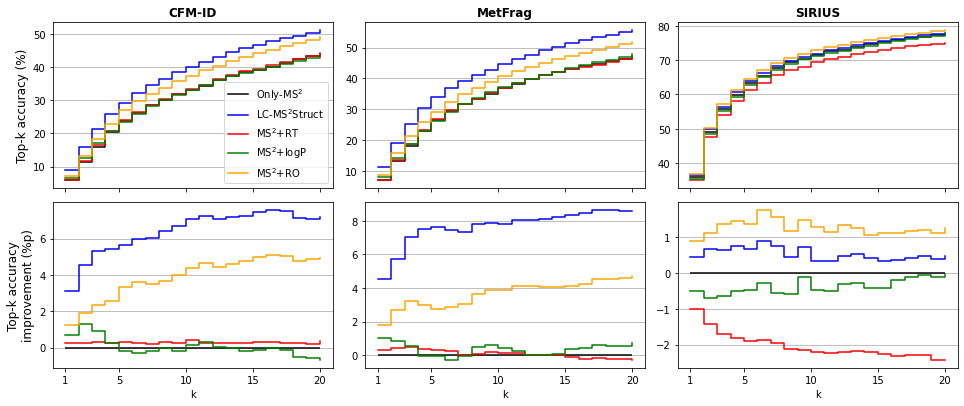

In [29]:
__tmp__01__a = plot__01__a(
    res__baseline=[
        res__ssvm__cfmid4[(res__ssvm__cfmid4["scoring_method"] == "Only MS") & (res__ssvm__cfmid4["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="CFM-ID"),
        res__ssvm__metfrag[(res__ssvm__metfrag["scoring_method"] == "Only MS") & (res__ssvm__metfrag["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="MetFrag"),
        res__ssvm__sirius[(res__ssvm__sirius["scoring_method"] == "Only MS") & (res__ssvm__sirius["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="SIRIUS")
    ], 
    res__ssvm=[
        res__ssvm__cfmid4[(res__ssvm__cfmid4["scoring_method"] == "MS + RT") & (res__ssvm__cfmid4["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct", ms2scorer="CFM-ID"),
        res__ssvm__metfrag[(res__ssvm__metfrag["scoring_method"] == "MS + RT") & (res__ssvm__metfrag["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct", ms2scorer="MetFrag"),
        res__ssvm__sirius[(res__ssvm__sirius["scoring_method"] == "MS + RT") & (res__ssvm__sirius["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct", ms2scorer="SIRIUS")
    ],
    res__rtfilter=[
        res__rtfilter__cfmid4[(res__rtfilter__cfmid4["scoring_method"] == "MS + RT (filtering__global)")].assign(scoring_method="MS$^2$+RT", ms2scorer="CFM-ID"),
        res__rtfilter__metfrag[(res__rtfilter__metfrag["scoring_method"] == "MS + RT (filtering__global)")].assign(scoring_method="MS$^2$+RT", ms2scorer="MetFrag"),
        res__rtfilter__sirius[(res__rtfilter__sirius["scoring_method"] == "MS + RT (filtering__global)")].assign(scoring_method="MS$^2$+RT", ms2scorer="SIRIUS")
    ],
    res__xlogp3=[
        res__xlogp3__cfmid4[(res__xlogp3__cfmid4["scoring_method"] == "MS + RT (score_combination)")].assign(scoring_method="MS$^2$+logP", ms2scorer="CFM-ID"),
        res__xlogp3__metfrag[(res__xlogp3__metfrag["scoring_method"] == "MS + RT (score_combination)")].assign(scoring_method="MS$^2$+logP", ms2scorer="MetFrag"),
        res__xlogp3__sirius[(res__xlogp3__sirius["scoring_method"] == "MS + RT (score_combination)")].assign(scoring_method="MS$^2$+logP", ms2scorer="SIRIUS")
    ],
    res__bach2020=[
        res__bach2020__cfmid4[(res__bach2020__cfmid4["scoring_method"] == "MS + RT (msms_pl_rt_score_integration)")].assign(scoring_method="MS$^2$+RO", ms2scorer="CFM-ID"),
        res__bach2020__metfrag[(res__bach2020__metfrag["scoring_method"] == "MS + RT (msms_pl_rt_score_integration)")].assign(scoring_method="MS$^2$+RO", ms2scorer="MetFrag"),
        res__bach2020__sirius[(res__bach2020__sirius["scoring_method"] == "MS + RT (msms_pl_rt_score_integration)")].assign(scoring_method="MS$^2$+RO", ms2scorer="SIRIUS")
    ],
    max_k=20,
    weighted_average=False,
    raise_on_missing_results=False,
    aspect="landscape",
    verbose=True
)

for ext in ["pdf", "svg"]:
    plt.savefig(os.path.join(".", os.extsep.join(["plot_01__a", ext])))

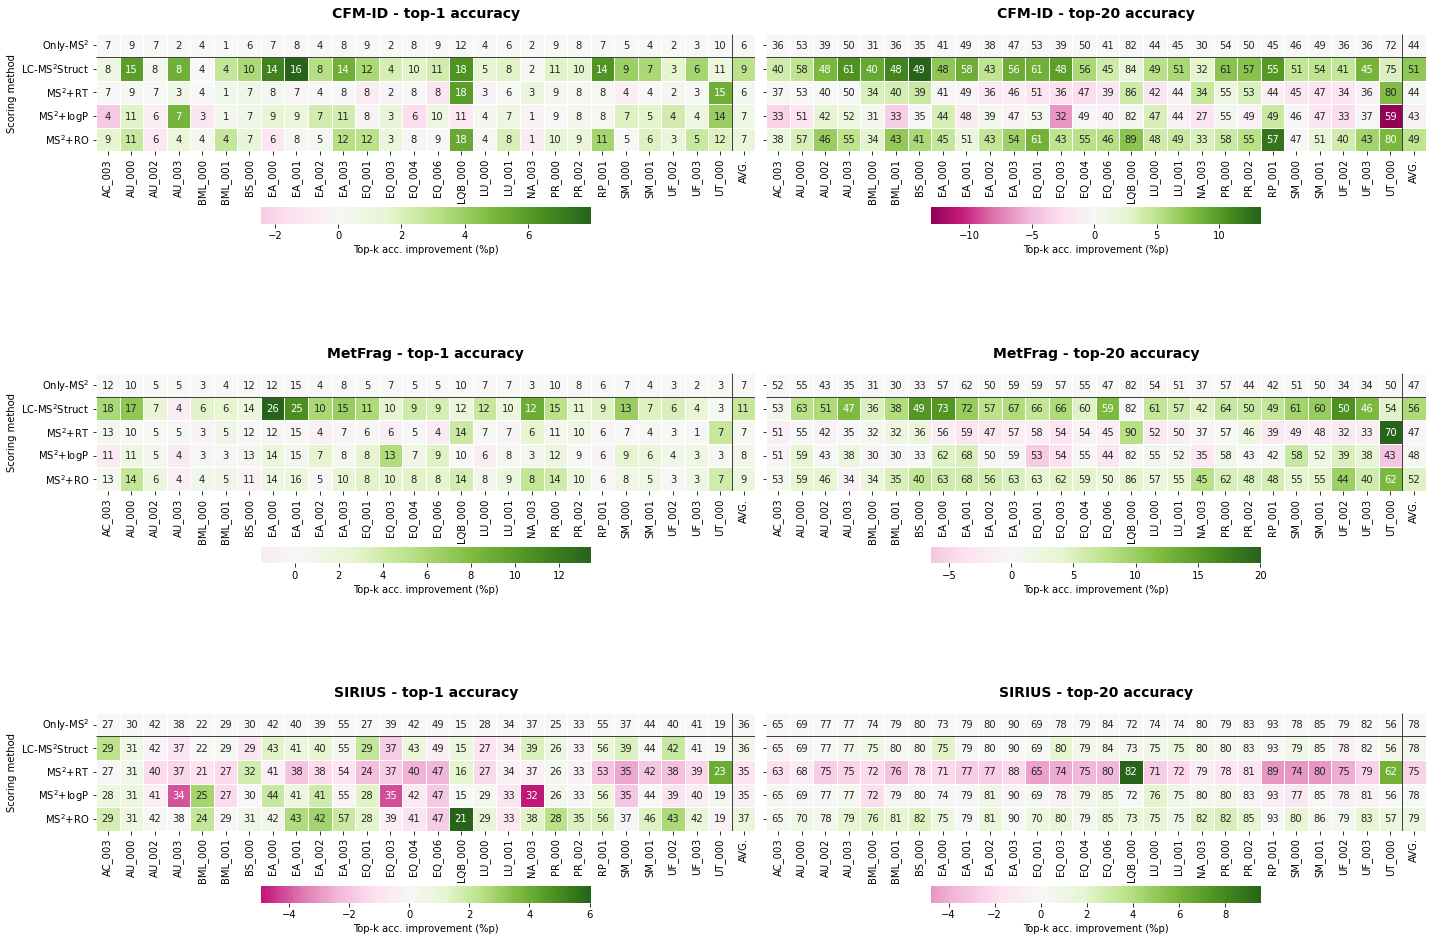

In [30]:
__tmp__01__b = plot__01__b(
    res__baseline=[
        res__ssvm__cfmid4[(res__ssvm__cfmid4["scoring_method"] == "Only MS") & (res__ssvm__cfmid4["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="CFM-ID"),
        res__ssvm__metfrag[(res__ssvm__metfrag["scoring_method"] == "Only MS") & (res__ssvm__metfrag["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="MetFrag"),
        res__ssvm__sirius[(res__ssvm__sirius["scoring_method"] == "Only MS") & (res__ssvm__sirius["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="SIRIUS")
    ], 
    res__ssvm=[
        res__ssvm__cfmid4[(res__ssvm__cfmid4["scoring_method"] == "MS + RT") & (res__ssvm__cfmid4["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct", ms2scorer="CFM-ID"),
        res__ssvm__metfrag[(res__ssvm__metfrag["scoring_method"] == "MS + RT") & (res__ssvm__metfrag["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct", ms2scorer="MetFrag"),
        res__ssvm__sirius[(res__ssvm__sirius["scoring_method"] == "MS + RT") & (res__ssvm__sirius["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct", ms2scorer="SIRIUS")
    ],
    res__rtfilter=[
        res__rtfilter__cfmid4[(res__rtfilter__cfmid4["scoring_method"] == "MS + RT (filtering__global)")].assign(scoring_method="MS$^2$+RT", ms2scorer="CFM-ID"),
        res__rtfilter__metfrag[(res__rtfilter__metfrag["scoring_method"] == "MS + RT (filtering__global)")].assign(scoring_method="MS$^2$+RT", ms2scorer="MetFrag"),
        res__rtfilter__sirius[(res__rtfilter__sirius["scoring_method"] == "MS + RT (filtering__global)")].assign(scoring_method="MS$^2$+RT", ms2scorer="SIRIUS")
    ],
    res__xlogp3=[
        res__xlogp3__cfmid4[(res__xlogp3__cfmid4["scoring_method"] == "MS + RT (score_combination)")].assign(scoring_method="MS$^2$+logP", ms2scorer="CFM-ID"),
        res__xlogp3__metfrag[(res__xlogp3__metfrag["scoring_method"] == "MS + RT (score_combination)")].assign(scoring_method="MS$^2$+logP", ms2scorer="MetFrag"),
        res__xlogp3__sirius[(res__xlogp3__sirius["scoring_method"] == "MS + RT (score_combination)")].assign(scoring_method="MS$^2$+logP", ms2scorer="SIRIUS")
    ],
    res__bach2020=[
        res__bach2020__cfmid4[(res__bach2020__cfmid4["scoring_method"] == "MS + RT (msms_pl_rt_score_integration)")].assign(scoring_method="MS$^2$+RO", ms2scorer="CFM-ID"),
        res__bach2020__metfrag[(res__bach2020__metfrag["scoring_method"] == "MS + RT (msms_pl_rt_score_integration)")].assign(scoring_method="MS$^2$+RO", ms2scorer="MetFrag"),
        res__bach2020__sirius[(res__bach2020__sirius["scoring_method"] == "MS + RT (msms_pl_rt_score_integration)")].assign(scoring_method="MS$^2$+RO", ms2scorer="SIRIUS")
    ],
    ks=[1, 20],
    weighted_average=False,
    raise_on_missing_results=False,
    ctype="improvement",
    label_format=".0f"
)

for ext in ["pdf", "svg"]:
    plt.savefig(os.path.join(".", os.extsep.join(["plot_01__b", ext])))